# Image operations

Image operations are functions unique to medical imaging without a similar counterpart in numpy. Such functions exist because medical images (and images in general) have a more meaningful and structured interpretation compared to normal arrays. In this chapter, we will first give you an introduction of the basic preprocessing steps you may need to get your images into a "trainable" form. Then, we will go over many of the image operations that you can perform with ants. 

The image operations presented here will be directly useful when you start training medical imaging AI models. Some of the operations will be helpful for processing your images before training, while many of them will be important parts of data augmentation which will be discussed later. In other words, these operations are necessary for training good medical imaging AI models.

## Preprocessing

Let's start by discussing the basic preprocessing operations you may want to apply to your medical images. These operations are fairly standard - especially for brain images - for getting raw images into a "trainable" form. We will first load a 3D brain image to work on.

In [7]:
import ants
img = ants.image_read(ants.get_data('r16'))

### Bias field correction

Images generally have a bias field from the scanner that needs to be corrected. The ants library provides a bias field correction function to help you here.

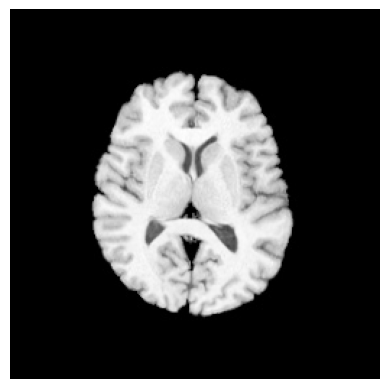

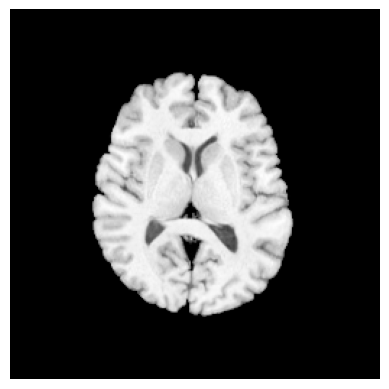

In [8]:
img2 = ants.n4_bias_field_correction(img)
ants.plot(img)
ants.plot(img2)

### Registration

You may need at some point need to align two images to each other. This task is called `registration`, and it can be done to varying degrees in terms of how much you change the image. Here is a general overview of the three main types of registration we will cover.

- Rigid: put two images in generally the same location using only translation and rotation
- Affine: make two images have the same general location and size using rigid translations + shearing and scaling
- SyN: align the actual features of two images using non-linear warping / distortion fields

You can see how these different types of registration alter the `moving` image to fit the `fixed` image.

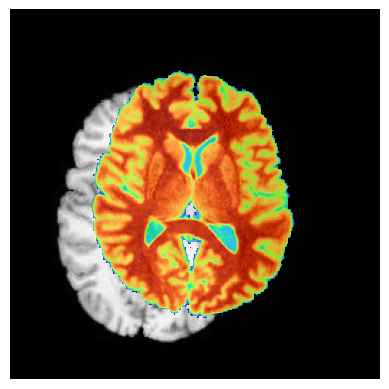

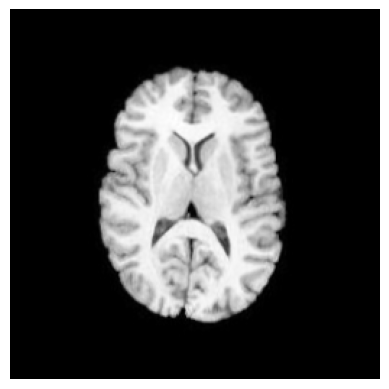

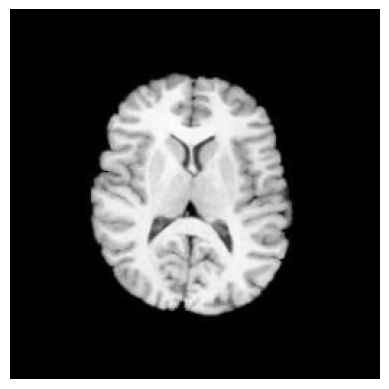

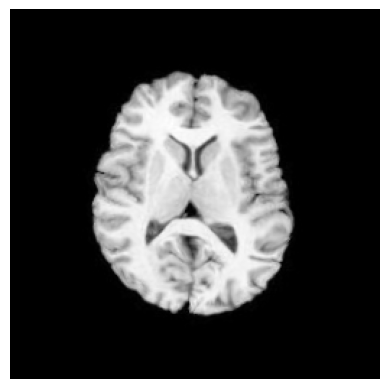

In [29]:
fixed = ants.image_read(ants.get_data('r16'))
moving = ants.image_read(ants.get_data('r64'))

res_rigid = ants.registration(fixed, moving, type_of_transform='Rigid')
res_affine = ants.registration(fixed, moving, type_of_transform='Affine')
res_syn = ants.registration(fixed, moving, type_of_transform='SyN')

ants.plot(moving, fixed)
ants.plot(res_rigid['warpedmovout'])
ants.plot(res_affine['warpedmovout'])
ants.plot(res_syn['warpedmovout'])

The Affine and SyN registration may look quite similar to each other, but the difference is perhaps most visible in the ventricles of the two images. Notice how the SyN-registered moving image has wider ventricles to match that of the fixed image compared to the relatively narrower ventricles in the original moving image. We can visualize this difference by subtracting the two images from each other.

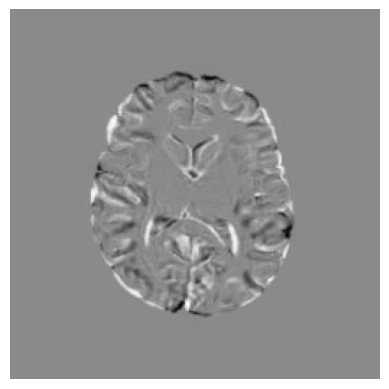

In [27]:
ants.plot(res_affine['warpedmovout'] - res_syn['warpedmovout'])

The white areas in the image show where tissue in the SyN-registered image has been expanded outward compared to the Affine-registered image. You can also get an understanding of non-linear registration results using the so-called Jacobian image. For those that are interested in going further with medical image registration, the ants library will get you far. The ants registration algorithms still make up a vital part of many traditional image processing pipelines.

### Segmentation

## Intensity

Key image operations include morphological functions such as opening and closing. These functions are particularly useful when you are working with segmentation images with discrete labels or masks. 

## Spatial

## Structural

## Segmentation